# Task 5.

### CNN Task: Multi-Tank Classification

### Objective
Develop a Convolutional Neural Network (CNN) to classify images of military tanks using the "Military Tanks Dataset Images" from Kaggle.

## Steps

1. **Data Acquisition**
   - Import necessary libraries (Torch or TensorFlow/Keras, pandas, numpy, etc.).
   - Load the dataset: `tank_images = 'path_to_dataset_directory'`.

2. **Data Preprocessing**
   - Perform image preprocessing (resizing, normalization).
   - Split the dataset into training, validation, and testing sets.

3. **CNN Model Development**
   - Define a CNN model architecture using Torch or Keras.
   - Consider using data augmentation techniques.

4. **Training the Model**
   - Compile the CNN model.
   - Train the model on the training dataset.
   - Use validation data to tune hyperparameters.

5. **Model Evaluation**
   - Evaluate the model's performance on the test set.
   - Analyze the classification accuracy and loss.

6. **Fine-Tuning and Optimization**
   - Adjust model architecture and parameters for better performance.
   - Re-train and evaluate the model.

7. **Conclusion**
   - Summarize the model's performance.
   - Suggest potential improvements or further research areas.

## Dataset
Download from: [Kaggle - Military Tanks Dataset Images](https://www.kaggle.com/datasets/antoreepjana/military-tanks-dataset-images)


In [1]:
# Imports
import os
import pathlib
import logging
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from torchinfo import summary
from tqdm import tqdm

c:\Users\Sanya\kapitonnov_nn_n00b\neural_n00b\nn_n00b_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up the Logs for the first time
logging.basicConfig(level=logging.INFO)
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(messages)s")
logging.basicConfig(filename="./logs/hw5_logs.log", level=logging.INFO)

In [3]:
# Setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"

Our datasets doesn't have train and test split

In [4]:
# Set path to our data
data = pathlib.Path('data/')
tank_data_path = data / "tank_images/"

In [5]:
# Take a look at our data folder and number of images in it
number_of_files = 0
for (roots, _, files) in os.walk(tank_data_path):
    print(roots, "Num of files in directory: ", len(files))
    number_of_files+=len(files)
print("\nTotal num of imgs: ", number_of_files)

print("\nAverage number of images in a folder: ", number_of_files/(len(list(os.walk(tank_data_path)))-1))

data\tank_images Num of files in directory:  0
data\tank_images\test Num of files in directory:  0
data\tank_images\test\altay Num of files in directory:  2
data\tank_images\test\al_khalid Num of files in directory:  2
data\tank_images\test\amx_13 Num of files in directory:  2
data\tank_images\test\amx_30 Num of files in directory:  2
data\tank_images\test\amx_32 Num of files in directory:  2
data\tank_images\test\amx_40 Num of files in directory:  2
data\tank_images\test\anders Num of files in directory:  2
data\tank_images\test\ariete Num of files in directory:  2
data\tank_images\test\arjun Num of files in directory:  2
data\tank_images\test\arjun_mk2 Num of files in directory:  2
data\tank_images\test\armata Num of files in directory:  2
data\tank_images\test\bmpt Num of files in directory:  3
data\tank_images\test\bmpt_72 Num of files in directory:  2
data\tank_images\test\bmt_72 Num of files in directory:  2
data\tank_images\test\btmp_84 Num of files in directory:  1
data\tank_im

In [6]:
# Looking through the paths with images to understand the structure of dirs
for (roots, _, files) in os.walk(tank_data_path):
    print(roots, files)

data\tank_images []
data\tank_images\test []
data\tank_images\test\altay ['altay_l7.jpg', 'altay_main.jpg']
data\tank_images\test\al_khalid ['al_khalid_l5.jpg', 'al_khalid_main.jpg']
data\tank_images\test\amx_13 ['amx_13_l5.jpg', 'amx_13_main.jpg']
data\tank_images\test\amx_30 ['amx_30_l7.jpg', 'amx_30_main.jpg']
data\tank_images\test\amx_32 ['amx_32_l5.jpg', 'amx_32_main.jpg']
data\tank_images\test\amx_40 ['amx_40_l4.jpg', 'amx_40_main.jpg']
data\tank_images\test\anders ['anders_l8.jpg', 'anders_main.jpg']
data\tank_images\test\ariete ['ariete_l4.jpg', 'ariete_main.jpg']
data\tank_images\test\arjun ['arjun_l8.jpg', 'arjun_main.jpg']
data\tank_images\test\arjun_mk2 ['arjun_mk2_l4.jpg', 'arjun_mk2_main.jpg']
data\tank_images\test\armata ['armata_l8.jpg', 'armata_main.jpg']
data\tank_images\test\bmpt ['bmpt_l8.jpg', 'bmpt_l9.jpg', 'bmpt_main.jpg']
data\tank_images\test\bmpt_72 ['bmpt_72_l6.jpg', 'bmpt_72_main.jpg']
data\tank_images\test\bmt_72 ['bmt_72_l6.jpg', 'bmt_72_main.jpg']
data\ta

In [7]:
# Here I'm restructuring our data directories to the "right form" to easily fit it to pytorch workflow 


# Restart
shutil.rmtree(tank_data_path)

# Create a proper structure for ImageFolder datasets
test_split = 0.2
name_index = 17

# Unzip tank_imgs archive
with zipfile.ZipFile('data/tank_imgs.zip', 'r') as f:
    f.extractall(path=data)

# Creating train and test folders if such don't exist
train_tank_dir = pathlib.Path("data/tank_images/train")
test_tank_dir = pathlib.Path("data/tank_images/test")
if not train_tank_dir.is_dir():
    train_tank_dir.mkdir()
if not test_tank_dir.is_dir():
    test_tank_dir.mkdir()

# Iter through dirs with tank imgs and move them to train and test folders  
for (roots, dirs, files) in os.walk(tank_data_path):
    train_im_num = len(files) - int(test_split*len(files)) # Counts 80% of images in folder for training
    # Splits !dirs! in train/test (This block will run ones!)
    for dir in dirs:
        if dir in ["train", "test"]:
            continue
        if not (train_tank_dir/dir).is_dir():
            (train_tank_dir/dir).mkdir()
        if not (test_tank_dir/dir).is_dir():
            (test_tank_dir/dir).mkdir()
    # Split !images! into train/test
    for i, file in enumerate(files, start=1):
        parents = [train_tank_dir, test_tank_dir]
        root = pathlib.Path(roots)
        if root.parent in parents:
            continue
        if i < train_im_num:
            file_a = pathlib.Path(f'{roots}\\{file}')
            file_b = train_tank_dir / f'{roots[name_index:]}\\{file}'
            file_a.rename(file_b)
        else:
            file_a = pathlib.Path(f'{roots}\\{file}')
            file_b = test_tank_dir / f'{roots[name_index:]}\\{file}'
            file_a.rename(file_b)
            
# Cleanup (delete all spare folders)
for (roots, dirs, files) in os.walk(tank_data_path):
    root = pathlib.Path(roots)
    for dir in dirs:
        if ((train_tank_dir != (root/dir).parent and test_tank_dir != (root/dir).parent) and ((root/dir) not in [train_tank_dir, test_tank_dir])) or len(os.listdir(root/dir))==0:
            shutil.rmtree(root / dir)

In [8]:
number_of_classes = len(os.listdir(test_tank_dir))

In [9]:
# Train image transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(3),
    transforms.Grayscale(),
    transforms.ToTensor()])

# Test image transformations
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor()])

# Hyperparameters for dataloaders
BATCHSIZE = 32
NUM_WORKERS = os.cpu_count()

# Creating datasets
raw_tank_dataset = ImageFolder(train_tank_dir)
train_dataset = ImageFolder(train_tank_dir, transform=train_transform)
test_dataset = ImageFolder(test_tank_dir, transform=test_transform)

# Store labels
class_names = train_dataset.classes

# Creating dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=NUM_WORKERS)

In [10]:
# Take a look if dataset is not empty
train_dataset[0][0]

tensor([[[0.9686, 0.9686, 0.9647,  ..., 0.9608, 0.9608, 0.9569],
         [0.9725, 0.9725, 0.9686,  ..., 0.9608, 0.9608, 0.9569],
         [0.9765, 0.9725, 0.9725,  ..., 0.9608, 0.9608, 0.9569],
         ...,
         [0.9882, 0.9882, 0.9882,  ..., 0.7333, 0.7804, 0.8471],
         [0.9882, 0.9882, 0.9882,  ..., 0.6745, 0.7686, 0.8706],
         [0.9882, 0.9882, 0.9882,  ..., 0.9412, 0.9412, 0.9098]]])

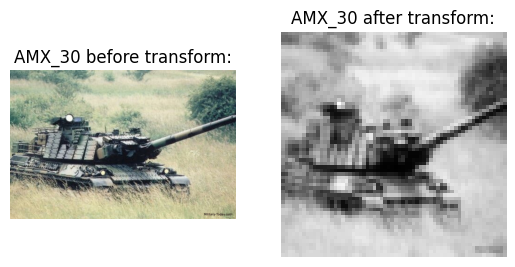

In [11]:
# Visualize images randomly
im_num = random.choice(range(len(class_names)))
raw_sample = raw_tank_dataset[im_num][0]
sample = train_dataset[im_num][0]
im_label = train_dataset[im_num][1]
plt.subplot(1, 2, 1)
plt.title(f'{class_names[im_label].upper()} before transform:')
plt.axis(False)
plt.imshow(raw_sample, cmap='gray');
plt.subplot(1, 2, 2)
plt.title(f'{class_names[im_label].upper()} after transform:')
plt.axis(False)
plt.imshow((sample).permute(1,2,0).numpy(), cmap='gray');

In [12]:
# Create a NN
class TankFinderModel_V0(nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()  # inherite the nn.Module atributes
        self.conv_layer_1 = nn.Sequential(  # the first convolution block
            nn.Conv2d(in_channels=input_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.classifier = nn.Sequential(  # classifier block
            nn.Flatten(),
            nn.Linear(in_features=hidden_nodes*58*58, out_features=64),
            nn.Linear(in_features=64, out_features=output_nodes),
            nn.Softmax()
        )
        
    def forward(self, x):  # overwrite the forward method
        return self.classifier(self.conv_layer_1(x))
    
class TankFinderModel_V1(nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()  # inherite the nn.Module atributes
        self.conv_layer_1 = nn.Sequential(  # the first convolution block
            nn.Conv2d(in_channels=input_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.conv_layer_2 = nn.Sequential(  # second convolution block
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.classifier = nn.Sequential(  # classifier block
            nn.Flatten(),
            nn.Linear(in_features=hidden_nodes*52*52, out_features=64),
            nn.Linear(in_features=64, out_features=output_nodes),
            nn.Softmax()
        )
        
    def forward(self, x):  # overwrite the forward method
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))
    
    
class TankFinderModel_V2(nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()  # inherite the nn.Module atributes
        self.conv_layer_1 = nn.Sequential(  # the first convolution block
            nn.Conv2d(in_channels=input_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.conv_layer_2 = nn.Sequential(  # second convolution block
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.classifier = nn.Sequential(  # classifier block
            nn.Flatten(),
            nn.Linear(in_features=hidden_nodes*46*46, out_features=64),
            nn.Linear(in_features=64, out_features=output_nodes),
            nn.Softmax()
        )
        
    def forward(self, x):  # overwrite the forward method
        return self.classifier(self.conv_layer_2(self.conv_layer_2(self.conv_layer_1(x))))
    
    
class TankFinderModel_V3(nn.Module):
    def __init__(self, input_nodes, output_nodes):
        super().__init__()  # inherite the nn.Module atributes
        self.conv_layer_1 = nn.Sequential(  # the first convolution block
            nn.Conv2d(in_channels=input_nodes, out_channels=512, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.conv_layer_2 = nn.Sequential(  # second convolution block
            nn.Conv2d(in_channels=256, out_channels=128, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        x = torch.randn(1, 1, 64, 64)  # Adjust for 1-channel input
        self.flattened_size = (self.conv_layer_2(self.conv_layer_1(x))).view(-1).shape[0]
        self.classifier = nn.Sequential(  # classifier block
            nn.Flatten(),
            nn.Linear(in_features=self.flattened_size, out_features=128),
            nn.Linear(in_features=128, out_features=output_nodes),
            nn.Softmax()
        )
    def forward(self, x):  # overwrite the forward method
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))
        

In [13]:
# Create an instance of our model (do not forget to set it to device)
model_V0 = TankFinderModel_V3(input_nodes=1, output_nodes=number_of_classes).to(device=device)

In [14]:
# Take a look at model architecture
model_V0

TankFinderModel_V3(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=173056, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=150, bias=True)
    (3): Softmax(dim=None)
  )
)

In [15]:
# Take a look at the number of parameters
summary(model_V0)

Layer (type:depth-idx)                   Param #
TankFinderModel_V3                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       5,120
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       1,179,904
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       295,040
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       73,792
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      22,151,296
│    └─Linear: 2-13                      19,350
│    └─Softmax: 2-14                     --
Total params: 23,724,502
Trainable params: 23,724,502
Non-trainable params: 0

In [63]:
# Accuracy function
def accuracy_fn(y_preds: torch.tensor, y_true: torch.tensor) -> float:  # made my own accuracy function
    """Returns a percentage of correct predictions to all predictions"""
    y_preds = torch.argmax(y_preds, dim=1)  # find the predicted class
    correct = y_true.detach().cpu().numpy() == y_preds.detach().cpu().numpy()  # compare our predictions to ground truth
    res = (correct.sum() / len(y_preds))*100  # calculate the ratio of correct predictions * 100
    return res

In [64]:
# Functionize our code a bit


# Setup options
EPOCHS = 5  # our epochs hyperparameter
LR = 0.001  # our learning rate hyperparameter
loss_func = nn.CrossEntropyLoss()  # select our loss function
optim = torch.optim.Adam(params=model_V0.parameters(), lr=LR)  # select optimizer

# Training func
def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device, epoch):
    model.train()  # set the model to training mode
    mean_loss, mean_acc = 0, 0  # keep track of our metrics
    progress_bar = tqdm(  # a nice loading bar 
      enumerate(dataloader, start=1), 
      desc=f"Training Epoch {epoch}", 
      total=len(dataloader)
      )
    for batch, (X, y) in progress_bar:  # iterate through our dataloaders
        X, y = X.to(device), y.to(device)  # set our tensors to the current device to avoid exeptions
        logits = model(X)  # store our inference into logits variable
        loss = loss_fn(logits, y)  # calculate our loss function
        acc = accuracy_fn(logits, y)  # calculate our metrics (in this case accuracy)
        optimizer.zero_grad()  # reset our gradience
        loss.backward()  # calculate our losses for weights
        optimizer.step()  # backpropagate through our network
        logging.info('')
        logging.info(f'Train Loss: {loss} || Train accuracy: {acc} Batch №: {batch}')
        mean_loss += loss.item()  # save the value of our loss
        mean_acc += acc  # save the value of our accuracy
    mean_loss /= batch  # find the mean loss
    mean_acc /= batch  # find the mean accuracy
    logging.info(f'Mean Train Loss: {mean_loss} || Mean Train acc: {mean_acc}')
    return mean_loss, mean_acc  # return results
    
# Testing func
def test_step(model, dataloader, loss_fn, acc_fn, device, epoch):
    model.eval()  # set our model to evaluation mode for testing
    mean_loss, mean_acc = 0, 0  # keep track of our metrics
    progress_bar = tqdm(  # a nice loading bar
      enumerate(dataloader, start=1), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader)
      )
    with torch.no_grad():  # disable gradience (```torch.inference_mode()``` is also a thing, but i heard it's a bit buggy in 2.0)
        for batch, (X, y) in progress_bar:  # iterate through our dataloaders
            X, y = X.to(device), y.to(device)  # set our tensors to the current device to avoid exeptions
            preds = model(X)  # store our inference into logits variable
            loss = loss_fn(preds, y)  # calculate our loss function
            acc = accuracy_fn(preds, y)  # calculate our metrics (in this case accuracy)
            logging.info('')
            logging.info(f'Test Loss: {loss} || Test accuracy: {acc} Batch №: {batch}')
            mean_loss += loss.item()  # save the value of our loss
            mean_acc += acc  # save the value of our ccuracy
        mean_loss /= batch  # find the mean loss
        mean_acc /= batch  # find the mean accuracy
        logging.info(f'Mean Train Loss: {mean_loss} || Mean Train acc: {mean_acc}')
    return mean_loss, mean_acc  # return results

# Training loop
def train(model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, device, epochs):
    # Dictionary of our metrics to keep track of them
    results_of_train_test = {"train_loss": [],
                            "train_acc": [],
                            "test_loss": [],
                            "test_acc": []}
    # Here we finally do the training and testing of our model, store the metrics of each epoch and return it
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, acc_fn, optimizer, device, epoch)
        results_of_train_test["train_loss"].append(train_loss)
        results_of_train_test["train_acc"].append(train_acc)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, acc_fn, device, epoch)
        results_of_train_test["test_loss"].append(test_loss)
        results_of_train_test["test_acc"].append(test_acc)
    return results_of_train_test

In [65]:
# Collect our results
results = train(model=model_V0, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader,
                loss_fn=loss_func,
                acc_fn=True,
                optimizer=optim,
                device=device,
                epochs=EPOCHS)

Training Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 1
Training Epoch 1:   4%|▍         | 1/24 [00:17<06:39, 17.38s/it]

32


INFO:root:
INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 2
Training Epoch 1:   8%|▊         | 2/24 [00:17<02:45,  7.52s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 3
Training Epoch 1:  12%|█▎        | 3/24 [00:18<01:30,  4.30s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 4
Training Epoch 1:  17%|█▋        | 4/24 [00:19<01:02,  3.15s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 5
Training Epoch 1:  21%|██        | 5/24 [00:20<00:40,  2.15s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 6
Training Epoch 1:  25%|██▌       | 6/24 [00:20<00:27,  1.55s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 7
Training Epoch 1:  29%|██▉       | 7/24 [00:21<00:21,  1.29s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 8
Training Epoch 1:  33%|███▎      | 8/24 [00:22<00:18,  1.13s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 9
Training Epoch 1:  38%|███▊      | 9/24 [00:24<00:20,  1.40s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 10
Training Epoch 1:  42%|████▏     | 10/24 [00:24<00:15,  1.09s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 11
Training Epoch 1:  46%|████▌     | 11/24 [00:25<00:12,  1.04it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 12
Training Epoch 1:  50%|█████     | 12/24 [00:25<00:09,  1.23it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 13
Training Epoch 1:  54%|█████▍    | 13/24 [00:26<00:07,  1.46it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 14
Training Epoch 1:  58%|█████▊    | 14/24 [00:26<00:05,  1.68it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 15
Training Epoch 1:  62%|██████▎   | 15/24 [00:26<00:04,  1.87it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 16
Training Epoch 1:  67%|██████▋   | 16/24 [00:27<00:03,  2.04it/s]INFO:root:


32


INFO:root:Train Loss: 4.928274154663086 || Train accuracy: 9.375 Batch №: 17
Training Epoch 1:  71%|███████   | 17/24 [00:27<00:03,  2.17it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 18
Training Epoch 1:  75%|███████▌  | 18/24 [00:28<00:02,  2.28it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 19
Training Epoch 1:  79%|███████▉  | 19/24 [00:28<00:02,  2.36it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 20
Training Epoch 1:  83%|████████▎ | 20/24 [00:28<00:01,  2.41it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 21
Training Epoch 1:  88%|████████▊ | 21/24 [00:29<00:01,  2.46it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 22
Training Epoch 1:  92%|█████████▏| 22/24 [00:29<00:00,  2.49it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 23
Training Epoch 1:  96%|█████████▌| 23/24 [00:29<00:00,  2.50it/s]INFO:root:


29


INFO:root:Train Loss: 5.022024631500244 || Train accuracy: 0.0 Batch №: 24
Training Epoch 1: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]
INFO:root:Mean Train Loss: 5.0116075078646345 || Mean Train acc: 1.0416666666666667
Testing Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 1
Testing Epoch 1:  10%|█         | 1/10 [00:22<03:25, 22.85s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 2
Testing Epoch 1:  20%|██        | 2/10 [00:23<01:15,  9.50s/it]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 3
Testing Epoch 1:  30%|███       | 3/10 [00:26<00:47,  6.83s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 4
Testing Epoch 1:  40%|████      | 4/10 [00:26<00:25,  4.20s/it]INFO:root:
INFO:root:Test Loss: 4.959524154663086 || Test accuracy: 6.25 Batch №: 5
Testing Epoch 1:  50%|█████     | 5/10 [00:26<00:13,  2.73s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 6
Testing Epoch 1:  60%|██████    | 6/10 [00:27<00:07,  1.85s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 7
Testing Epoch 1:  70%|███████   | 7/10 [00:27<00:04,  1.54s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 8
Testing Epoch 1:  80%|████████  | 8/10 [00:28<00:02,  1.09s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 9
Testing Epoch 1:  90%|█████████ | 9/10 [00:29<00:01,  1.13s/it]

32


INFO:root:
INFO:root:Test Loss: 5.0220255851745605 || Test accuracy: 0.0 Batch №: 10
Testing Epoch 1: 100%|██████████| 10/10 [00:30<00:00,  1.03s/it]

26


Testing Epoch 1: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]
INFO:root:Mean Train Loss: 5.015774297714233 || Mean Train acc: 0.625
Training Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 1
Training Epoch 2:   4%|▍         | 1/24 [00:12<04:36, 12.03s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 2
Training Epoch 2:   8%|▊         | 2/24 [00:13<02:04,  5.68s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 3
Training Epoch 2:  12%|█▎        | 3/24 [00:13<01:08,  3.27s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 4
Training Epoch 2:  17%|█▋        | 4/24 [00:14<00:42,  2.14s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 5
Training Epoch 2:  21%|██        | 5/24 [00:14<00:28,  1.51s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 6
Training Epoch 2:  25%|██▌       | 6/24 [00:15<00:23,  1.32s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 7
Training Epoch 2:  29%|██▉       | 7/24 [00:15<00:17,  1.02s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 8
Training Epoch 2:  33%|███▎      | 8/24 [00:16<00:15,  1.01it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 9
Training Epoch 2:  38%|███▊      | 9/24 [00:17<00:15,  1.07s/it]INFO:root:


32


INFO:root:Train Loss: 4.959524154663086 || Train accuracy: 6.25 Batch №: 10
Training Epoch 2:  42%|████▏     | 10/24 [00:18<00:13,  1.07it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 11
Training Epoch 2:  46%|████▌     | 11/24 [00:19<00:11,  1.11it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 12
Training Epoch 2:  50%|█████     | 12/24 [00:20<00:09,  1.25it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 13
Training Epoch 2:  54%|█████▍    | 13/24 [00:20<00:07,  1.47it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 14
Training Epoch 2:  58%|█████▊    | 14/24 [00:20<00:05,  1.68it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 15
Training Epoch 2:  62%|██████▎   | 15/24 [00:21<00:04,  1.87it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 16
Training Epoch 2:  67%|██████▋   | 16/24 [00:21<00:03,  2.03it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 17
Training Epoch 2:  71%|███████   | 17/24 [00:21<00:03,  2.16it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 18
Training Epoch 2:  75%|███████▌  | 18/24 [00:22<00:02,  2.27it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 19
Training Epoch 2:  79%|███████▉  | 19/24 [00:22<00:02,  2.36it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 20
Training Epoch 2:  83%|████████▎ | 20/24 [00:23<00:01,  2.41it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 21
Training Epoch 2:  88%|████████▊ | 21/24 [00:23<00:01,  2.46it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 22
Training Epoch 2:  92%|█████████▏| 22/24 [00:23<00:00,  2.50it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 23
Training Epoch 2:  96%|█████████▌| 23/24 [00:24<00:00,  2.52it/s]INFO:root:


29


INFO:root:Train Loss: 4.987542152404785 || Train accuracy: 3.4482758620689653 Batch №: 24
Training Epoch 2: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
INFO:root:Mean Train Loss: 5.011472821235657 || Mean Train acc: 1.0551364942528736
Testing Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 1
Testing Epoch 2:  10%|█         | 1/10 [00:20<03:05, 20.62s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 2
Testing Epoch 2:  20%|██        | 2/10 [00:20<01:08,  8.57s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 3
Testing Epoch 2:  30%|███       | 3/10 [00:20<00:33,  4.72s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 4
Testing Epoch 2:  40%|████      | 4/10 [00:21<00:17,  2.91s/it]INFO:root:
INFO:root:Test Loss: 4.959524154663086 || Test accuracy: 6.25 Batch №: 5
Testing Epoch 2:  50%|█████     | 5/10 [00:21<00:09,  1.92s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 6
Testing Epoch 2:  60%|██████    | 6/10 [00:21<00:05,  1.31s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 7
Testing Epoch 2:  70%|███████   | 7/10 [00:22<00:03,  1.12s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 8
Testing Epoch 2:  80%|████████  | 8/10 [00:22<00:01,  1.24it/s]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 9
Testing Epoch 2:  90%|█████████ | 9/10 [00:22<00:00,  1.67it/s]

32
26


INFO:root:
INFO:root:Test Loss: 5.0220255851745605 || Test accuracy: 0.0 Batch №: 10
Testing Epoch 2: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]
INFO:root:Mean Train Loss: 5.015774297714233 || Mean Train acc: 0.625
Training Epoch 3:   0%|          | 0/24 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 1
Training Epoch 3:   4%|▍         | 1/24 [00:15<05:53, 15.36s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 2
Training Epoch 3:   8%|▊         | 2/24 [00:15<02:24,  6.56s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 3
Training Epoch 3:  12%|█▎        | 3/24 [00:16<01:18,  3.75s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 4
Training Epoch 3:  17%|█▋        | 4/24 [00:16<00:48,  2.43s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 5
Training Epoch 3:  21%|██        | 5/24 [00:16<00:32,  1.69s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 6
Training Epoch 3:  25%|██▌       | 6/24 [00:17<00:22,  1.25s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 7
Training Epoch 3:  29%|██▉       | 7/24 [00:17<00:16,  1.03it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 8
Training Epoch 3:  33%|███▎      | 8/24 [00:18<00:14,  1.14it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 9
Training Epoch 3:  38%|███▊      | 9/24 [00:18<00:10,  1.37it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 10
Training Epoch 3:  42%|████▏     | 10/24 [00:20<00:15,  1.14s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 11
Training Epoch 3:  46%|████▌     | 11/24 [00:21<00:12,  1.04it/s]INFO:root:


32


INFO:root:Train Loss: 4.959524154663086 || Train accuracy: 6.25 Batch №: 12
Training Epoch 3:  50%|█████     | 12/24 [00:22<00:10,  1.11it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 13
Training Epoch 3:  54%|█████▍    | 13/24 [00:22<00:08,  1.34it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 14
Training Epoch 3:  58%|█████▊    | 14/24 [00:22<00:06,  1.57it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 15
Training Epoch 3:  62%|██████▎   | 15/24 [00:23<00:05,  1.77it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 16
Training Epoch 3:  67%|██████▋   | 16/24 [00:23<00:04,  1.95it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 17
Training Epoch 3:  71%|███████   | 17/24 [00:24<00:03,  2.11it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 18
Training Epoch 3:  75%|███████▌  | 18/24 [00:24<00:02,  2.23it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 19
Training Epoch 3:  79%|███████▉  | 19/24 [00:24<00:02,  2.33it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 20
Training Epoch 3:  83%|████████▎ | 20/24 [00:25<00:01,  2.41it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 21
Training Epoch 3:  88%|████████▊ | 21/24 [00:25<00:01,  2.47it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 22
Training Epoch 3:  92%|█████████▏| 22/24 [00:26<00:00,  2.51it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 23
Training Epoch 3:  96%|█████████▌| 23/24 [00:26<00:00,  2.53it/s]INFO:root:


29


INFO:root:Train Loss: 4.987542152404785 || Train accuracy: 3.4482758620689653 Batch №: 24
Training Epoch 3: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
INFO:root:Mean Train Loss: 5.011472821235657 || Mean Train acc: 1.0551364942528736
Testing Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 1
Testing Epoch 3:  10%|█         | 1/10 [00:20<03:00, 20.09s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 2
Testing Epoch 3:  20%|██        | 2/10 [00:20<01:06,  8.36s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 3
Testing Epoch 3:  30%|███       | 3/10 [00:20<00:32,  4.61s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 4
Testing Epoch 3:  40%|████      | 4/10 [00:20<00:17,  2.84s/it]

32
32


INFO:root:
INFO:root:Test Loss: 4.959524154663086 || Test accuracy: 6.25 Batch №: 5
Testing Epoch 3:  50%|█████     | 5/10 [00:20<00:09,  1.87s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 6
Testing Epoch 3:  60%|██████    | 6/10 [00:21<00:05,  1.42s/it]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 7
Testing Epoch 3:  70%|███████   | 7/10 [00:21<00:03,  1.13s/it]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 8
Testing Epoch 3:  80%|████████  | 8/10 [00:23<00:02,  1.37s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 9
Testing Epoch 3:  90%|█████████ | 9/10 [00:23<00:00,  1.02it/s]INFO:root:
INFO:root:Test Loss: 5.0220255851745605 || Test accuracy: 0.0 Batch №: 10
Testing Epoch 3: 100%|██████████| 10/10 [00:24<00:00,  1.00s/it]

26


Testing Epoch 3: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]
INFO:root:Mean Train Loss: 5.015774297714233 || Mean Train acc: 0.625
Training Epoch 4:   0%|          | 0/24 [00:00<?, ?it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 1
Training Epoch 4:   4%|▍         | 1/24 [00:17<06:40, 17.40s/it]INFO:root:


32


INFO:root:Train Loss: 4.959524154663086 || Train accuracy: 6.25 Batch №: 2
Training Epoch 4:   8%|▊         | 2/24 [00:19<03:05,  8.44s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 3
Training Epoch 4:  12%|█▎        | 3/24 [00:20<01:45,  5.02s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 4
Training Epoch 4:  17%|█▋        | 4/24 [00:21<01:09,  3.48s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 5
Training Epoch 4:  21%|██        | 5/24 [00:24<01:02,  3.29s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 6
Training Epoch 4:  25%|██▌       | 6/24 [00:25<00:43,  2.40s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 7
Training Epoch 4:  29%|██▉       | 7/24 [00:27<00:37,  2.19s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 8
Training Epoch 4:  33%|███▎      | 8/24 [00:29<00:34,  2.15s/it]INFO:root:


32


INFO:root:Train Loss: 4.959524154663086 || Train accuracy: 6.25 Batch №: 9
Training Epoch 4:  38%|███▊      | 9/24 [00:29<00:24,  1.60s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 10
Training Epoch 4:  42%|████▏     | 10/24 [00:31<00:24,  1.78s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 11
Training Epoch 4:  46%|████▌     | 11/24 [00:32<00:19,  1.49s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 12
Training Epoch 4:  50%|█████     | 12/24 [00:32<00:13,  1.15s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 13
Training Epoch 4:  54%|█████▍    | 13/24 [00:33<00:10,  1.08it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 14
Training Epoch 4:  58%|█████▊    | 14/24 [00:33<00:07,  1.30it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 15
Training Epoch 4:  62%|██████▎   | 15/24 [00:34<00:05,  1.52it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 16
Training Epoch 4:  67%|██████▋   | 16/24 [00:34<00:04,  1.72it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 17
Training Epoch 4:  71%|███████   | 17/24 [00:34<00:03,  1.91it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 18
Training Epoch 4:  75%|███████▌  | 18/24 [00:35<00:02,  2.02it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 19
Training Epoch 4:  79%|███████▉  | 19/24 [00:35<00:02,  2.14it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 20
Training Epoch 4:  83%|████████▎ | 20/24 [00:36<00:01,  2.25it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 21
Training Epoch 4:  88%|████████▊ | 21/24 [00:36<00:01,  2.27it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 22
Training Epoch 4:  92%|█████████▏| 22/24 [00:36<00:00,  2.34it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 23
Training Epoch 4:  96%|█████████▌| 23/24 [00:37<00:00,  2.37it/s]INFO:root:


29


INFO:root:Train Loss: 5.022024631500244 || Train accuracy: 0.0 Batch №: 24
Training Epoch 4: 100%|██████████| 24/24 [00:42<00:00,  1.75s/it]
INFO:root:Mean Train Loss: 5.0116075078646345 || Mean Train acc: 1.0416666666666667
Testing Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 1
Testing Epoch 4:  10%|█         | 1/10 [00:16<02:27, 16.40s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 2
Testing Epoch 4:  20%|██        | 2/10 [00:16<00:54,  6.84s/it]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 3
Testing Epoch 4:  30%|███       | 3/10 [00:18<00:31,  4.46s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 4
Testing Epoch 4:  40%|████      | 4/10 [00:18<00:16,  2.76s/it]INFO:root:
INFO:root:Test Loss: 4.959524154663086 || Test accuracy: 6.25 Batch №: 5
Testing Epoch 4:  50%|█████     | 5/10 [00:20<00:13,  2.69s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 6
Testing Epoch 4:  60%|██████    | 6/10 [00:21<00:07,  1.83s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 7
Testing Epoch 4:  70%|███████   | 7/10 [00:21<00:03,  1.28s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 8
Testing Epoch 4:  80%|████████  | 8/10 [00:21<00:01,  1.09it/s]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 9
Testing Epoch 4:  90%|█████████ | 9/10 [00:22<00:00,  1.15it/s]

32


INFO:root:
INFO:root:Test Loss: 5.0220255851745605 || Test accuracy: 0.0 Batch №: 10
Testing Epoch 4: 100%|██████████| 10/10 [00:22<00:00,  1.24it/s]

26


Testing Epoch 4: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]
INFO:root:Mean Train Loss: 5.015774297714233 || Mean Train acc: 0.625
Training Epoch 5:   0%|          | 0/24 [00:00<?, ?it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 1
Training Epoch 5:   4%|▍         | 1/24 [00:12<04:48, 12.54s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 2
Training Epoch 5:   8%|▊         | 2/24 [00:13<02:01,  5.53s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 3
Training Epoch 5:  12%|█▎        | 3/24 [00:13<01:06,  3.18s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 4
Training Epoch 5:  17%|█▋        | 4/24 [00:13<00:41,  2.08s/it]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 5
Training Epoch 5:  21%|██        | 5/24 [00:14<00:28,  1.47s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 6
Training Epoch 5:  25%|██▌       | 6/24 [00:14<00:20,  1.11s/it]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 7
Training Epoch 5:  29%|██▉       | 7/24 [00:15<00:14,  1.14it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 8
Training Epoch 5:  33%|███▎      | 8/24 [00:15<00:11,  1.38it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 9
Training Epoch 5:  38%|███▊      | 9/24 [00:15<00:09,  1.61it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 10
Training Epoch 5:  42%|████▏     | 10/24 [00:16<00:07,  1.81it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 11
Training Epoch 5:  46%|████▌     | 11/24 [00:16<00:06,  1.99it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 12
Training Epoch 5:  50%|█████     | 12/24 [00:17<00:05,  2.15it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 13
Training Epoch 5:  54%|█████▍    | 13/24 [00:17<00:04,  2.27it/s]INFO:root:


32


INFO:root:Train Loss: 4.959524154663086 || Train accuracy: 6.25 Batch №: 14
Training Epoch 5:  58%|█████▊    | 14/24 [00:17<00:04,  2.37it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 15
Training Epoch 5:  62%|██████▎   | 15/24 [00:18<00:03,  2.45it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 16
Training Epoch 5:  67%|██████▋   | 16/24 [00:18<00:03,  2.51it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 17
Training Epoch 5:  71%|███████   | 17/24 [00:18<00:02,  2.56it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 18
Training Epoch 5:  75%|███████▌  | 18/24 [00:19<00:02,  2.59it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 19
Training Epoch 5:  79%|███████▉  | 19/24 [00:19<00:01,  2.60it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 20
Training Epoch 5:  83%|████████▎ | 20/24 [00:20<00:01,  2.61it/s]INFO:root:


32


INFO:root:Train Loss: 4.990774154663086 || Train accuracy: 3.125 Batch №: 21
Training Epoch 5:  88%|████████▊ | 21/24 [00:20<00:01,  2.62it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 22
Training Epoch 5:  92%|█████████▏| 22/24 [00:20<00:00,  2.62it/s]INFO:root:


32


INFO:root:Train Loss: 5.022024154663086 || Train accuracy: 0.0 Batch №: 23
Training Epoch 5:  96%|█████████▌| 23/24 [00:21<00:00,  2.63it/s]INFO:root:


29


INFO:root:Train Loss: 5.022024631500244 || Train accuracy: 0.0 Batch №: 24
Training Epoch 5: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]
INFO:root:Mean Train Loss: 5.0116075078646345 || Mean Train acc: 1.0416666666666667
Testing Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 1
Testing Epoch 5:  10%|█         | 1/10 [00:23<03:33, 23.76s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 2
Testing Epoch 5:  20%|██        | 2/10 [00:23<01:18,  9.87s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 3
Testing Epoch 5:  30%|███       | 3/10 [00:24<00:37,  5.42s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 4
Testing Epoch 5:  40%|████      | 4/10 [00:24<00:20,  3.34s/it]

32
32


INFO:root:
INFO:root:Test Loss: 4.959524154663086 || Test accuracy: 6.25 Batch №: 5
Testing Epoch 5:  50%|█████     | 5/10 [00:24<00:10,  2.19s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 6
Testing Epoch 5:  60%|██████    | 6/10 [00:24<00:05,  1.49s/it]

32
32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 7
Testing Epoch 5:  70%|███████   | 7/10 [00:24<00:03,  1.05s/it]INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 8
Testing Epoch 5:  80%|████████  | 8/10 [00:24<00:01,  1.32it/s]

32


INFO:root:
INFO:root:Test Loss: 5.022024154663086 || Test accuracy: 0.0 Batch №: 9
Testing Epoch 5:  90%|█████████ | 9/10 [00:25<00:00,  1.18it/s]

32
26


INFO:root:
INFO:root:Test Loss: 5.0220255851745605 || Test accuracy: 0.0 Batch №: 10
Testing Epoch 5: 100%|██████████| 10/10 [00:31<00:00,  3.15s/it]
INFO:root:Mean Train Loss: 5.015774297714233 || Mean Train acc: 0.625


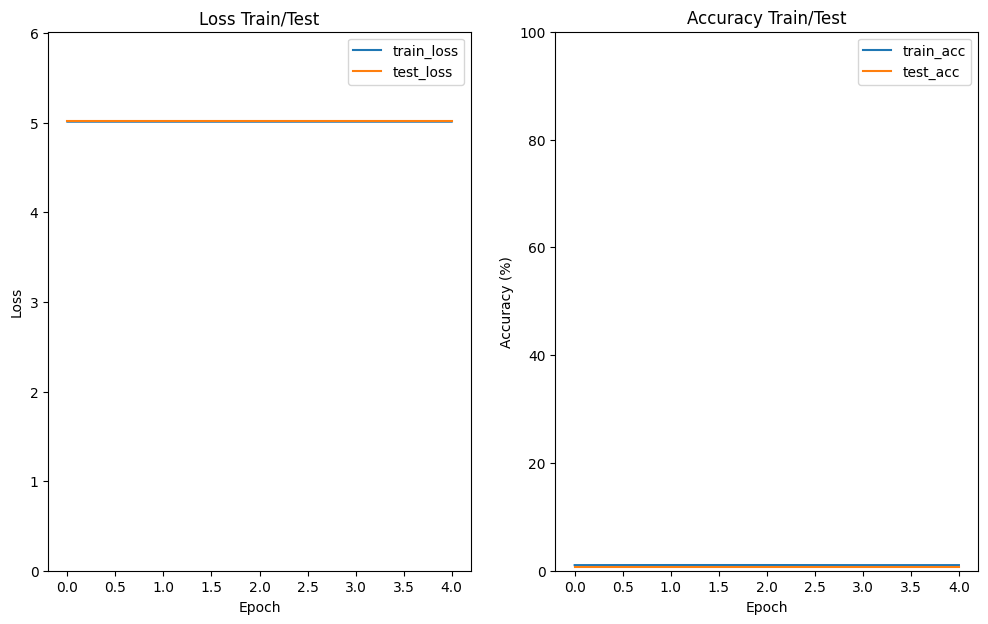

In [66]:
# Plot our results
fig = plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["test_loss"], label="test_loss")
plt.title("Loss Train/Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, max(max(results["train_loss"]), max(results["test_loss"]))+1])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results["train_acc"], label="train_acc")
plt.plot(results["test_acc"], label="test_acc")
plt.title("Accuracy Train/Test")
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()